
import pandas as pd
import numpy as np
from fastFM import sgd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy import sparse

df = pd.read_csv("dataset_final.csv")

X = df[['temporal_1', 'temporal_2', 'temporal_3']]
y = df['rating']

# 🔹 3. Normalizar features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertir a sparse matrix (porque fastFM necesita sparse)
X_sparse = sparse.csr_matrix(X_scaled)

# 🔹 4. Separar en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_sparse, y, test_size=0.2, random_state=42)

# 🔹 5. Crear el modelo Factorization Machine
fm = sgd.FMRegression(n_iter=1000, init_stdev=0.1, l2_reg_w=0.1, l2_reg_V=0.5, rank=8, random_state=42)

# 🔹 6. Entrenar el modelo
fm.fit(X_train, y_train)

# 🔹 7. Predecir
y_pred = fm.predict(X_test)

# 🔹 8. Evaluar con RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"\n🔍 RMSE obtenido en test: {rmse:.4f}")



In [33]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Ruta del archivo CSV
csv_path = "dataset_final_2.csv"

# Cargar el DataFrame
df_rnn_final = pd.read_csv(csv_path)

# Mostrar primeras filas para verificar
print("Datos cargados:")
# Seleccionar solo las columnas numéricas que usaremos como input
features_columns = [
    'temporal_1', 'temporal_2', 'temporal_3',
    'is_weekend', 'season_encoded', 'is_holiday',
    'year', 'month', 'weekday',
    'consumo_semanal_usuario'
]

# Opcional: agrega rating_previous si lo calculaste
# features_columns.append('rating_previous')

X = df_rnn_final[features_columns].values
y = df_rnn_final['rating'].values  # El objetivo a predecir
from collections import defaultdict

# Diccionario para guardar secuencias por usuario
user_sequences = defaultdict(list)
user_targets = defaultdict(list)

# Recorremos todo el dataset y vamos guardando por usuario
for idx, row in df_rnn_final.iterrows():
    user_id = row['userId']
    x = row[features_columns].values
    target = row['rating']

    user_sequences[user_id].append(x)
    user_targets[user_id].append(target)


Datos cargados:


In [34]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Convertimos a listas
sequences_list = list(user_sequences.values())
targets_list = np.array([t[-1] for t in user_targets.values()])

# Padding (rellenar con ceros al inicio)
maxlen = 50  # Máximo 50 interacciones por usuario
X_padded = pad_sequences(sequences_list, maxlen=maxlen, padding='pre', dtype='float32')

print("Forma de X_padded:", X_padded.shape)
print("Forma de y:", targets_list.shape)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_padded, targets_list, test_size=0.2, random_state=42)



Forma de X_padded: (200384, 50, 10)
Forma de y: (200384,)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 50, 10)            0         
                                                                 
 lstm (LSTM)                 (None, 64)                19200     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 19265 (75.25 KB)
Trainable params: 19265 (75.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5


2025-05-21 22:59:48.452499: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'cond_36/output/_23'


2505/2505 [==============================] - 223s 88ms/step - loss: 1.6205 - mae: 1.0163 - val_loss: 1.1217 - val_mae: 0.8562
Epoch 2/5
2505/2505 [==============================] - 222s 89ms/step - loss: 1.3124 - mae: 0.9106 - val_loss: 1.1095 - val_mae: 0.8403
Epoch 3/5
2505/2505 [==============================] - 222s 88ms/step - loss: 1.1918 - mae: 0.8668 - val_loss: 1.1148 - val_mae: 0.8510
Epoch 4/5
2505/2505 [==============================] - 220s 88ms/step - loss: 1.1443 - mae: 0.8507 - val_loss: 1.1093 - val_mae: 0.8425
Epoch 5/5
627/627 [==============================] - 10s 15ms/step

✅ Test Loss (MSE): 1.1086
✅ Test MAE: 0.8388
✅ Test RMSE: 1.0529


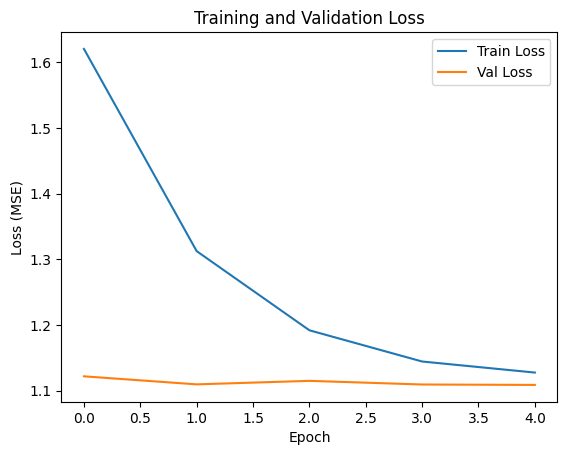

Modelo guardado como 'rnn_rating_model.h5'


/home/eduardo/PycharmProjects/Calculo_Entropia/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [35]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.callbacks import EarlyStopping

# Parámetros del modelo
input_shape = (X_train.shape[1], X_train.shape[2])  # maxlen, n_features
lstm_units = 64
dropout_rate = 0.4
learning_rate = 0.001

# Construcción del modelo
model = Sequential()

# Opcional: Capa Masking si usas padding ('mask_zero=True' en Embedding o aquí)
model.add(Masking(mask_value=0., input_shape=input_shape))

# Capa LSTM
model.add(LSTM(units=lstm_units, return_sequences=False))  # False porque solo queremos 1 salida por secuencia
model.add(Dropout(dropout_rate))

# Capa densa final para regresión
model.add(Dense(units=1, activation='linear'))  # Salida lineal para predecir el rating

# Compilación del modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mse',           # Error cuadrático medio
    metrics=['mae']       # Métrica adicional: error absoluto medio
)

# Mostrar resumen del modelo
model.summary()

# Callback para detener el entrenamiento si deja de mejorar
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=5,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# Evaluar en test
loss, mae = model.evaluate(X_test, y_test, verbose=0)

# Predecir y calcular RMSE manualmente
y_pred = model.predict(X_test, batch_size=64).flatten()
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Mostrar resultados finales
print(f"\n✅ Test Loss (MSE): {loss:.4f}")
print(f"✅ Test MAE: {mae:.4f}")
print(f"✅ Test RMSE: {rmse:.4f}")

import matplotlib.pyplot as plt

# Gráfica de pérdida
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Guardar modelo completo
model.save("rnn_rating_model12.h5")
print("Modelo guardado como 'rnn_rating_model.h5'")

### Predicciones

In [36]:
import pandas as pd

# Cargar CSV con userId, movieId, timestamp (y opcionalmente rating)
df_new = pd.read_csv("test.csv", sep=';')

# Mostrar ejemplo
print("Datos nuevos cargados:")
print(df_new.head())

Datos nuevos cargados:
   userId  movieId   timestamp
0   50403     1994   974714656
1   32443     2571  1595779316
2  188231     1387  1035549808
3   54812    49530  1321586136
4   32676     1704   992549210


In [37]:
# Convertir timestamp a datetime
df_new['date'] = pd.to_datetime(df_new['timestamp'], unit='s')
df_new['year'] = df_new['date'].dt.year
df_new['month'] = df_new['date'].dt.month
df_new['weekday'] = df_new['date'].dt.weekday

In [38]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'invierno'
    elif month in [3, 4, 5]:
        return 'primavera'
    elif month in [6, 7, 8]:
        return 'verano'
    else:
        return 'otoño'

df_new['season'] = df_new['month'].apply(get_season)
df_new['is_weekend'] = df_new['weekday'].isin([5, 6]).astype(int)

# Codificar estaciones
season_map = {'invierno': 0, 'primavera': 1, 'verano': 2, 'otoño': 3}
df_new['season_encoded'] = df_new['season'].map(season_map)

# Importar holidays si lo necesitas
import holidays
ecu_holidays = holidays.Ecuador(years=range(df_new['year'].min(), df_new['year'].max() + 1))
df_new['is_holiday'] = df_new['date'].isin(ecu_holidays).astype(int)

/tmp/ipykernel_36086/1724492501.py:21: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_new['is_holiday'] = df_new['date'].isin(ecu_holidays).astype(int)


In [39]:
# Semana del año
df_new['week_of_year'] = df_new['date'].dt.isocalendar().week.astype(int)

# Consumo semanal (cuenta de interacciones por usuario por semana)
consumo = df_new.groupby(['userId', 'week_of_year']).size().reset_index(name='consumo_semanal_usuario')
df_new = pd.merge(df_new, consumo, on=['userId', 'week_of_year'], how='left')

In [40]:
import joblib
import umap

# Cargar scaler y reducer UMAP guardados
scaler = joblib.load("scaler_temporal2.pkl")
reducer = joblib.load("umap_model2.pkl")

# Seleccionar features para UMAP
temporal_features = ['year', 'month', 'weekday', 'season_encoded', 'is_weekend', 'is_holiday']

# Escalar
X_scaled_new = scaler.transform(df_new[temporal_features])

# Aplicar UMAP
X_umap_new = reducer.transform(X_scaled_new)

# Agregar al DataFrame
df_new[['temporal_1', 'temporal_2', 'temporal_3']] = X_umap_new

/home/eduardo/PycharmProjects/Calculo_Entropia/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [41]:
features_columns = [
    'temporal_1', 'temporal_2', 'temporal_3',
    'is_weekend', 'season_encoded', 'is_holiday',
    'year', 'month', 'weekday',
    'consumo_semanal_usuario'
]

In [42]:
from collections import defaultdict

user_sequences_new = defaultdict(list)

for _, row in df_new.iterrows():
    user_id = row['userId']
    x = row[features_columns].values
    user_sequences_new[user_id].append(x)

In [43]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Convertir a lista de arrays
sequences_list_new = list(user_sequences_new.values())

# Padding (igual que en entrenamiento)
maxlen = 50  # Debe ser igual al maxlen usado antes
X_new_padded = pad_sequences(sequences_list_new, maxlen=maxlen, padding='pre', dtype='float32')

In [44]:
# Cargar modelo si no está cargado
from tensorflow.keras.models import load_model
model = load_model("rnn_rating_model12.h5")

# Hacer predicción
y_pred_new = model.predict(X_new_padded).flatten()

# Mostrar resultados por usuario
users_new = list(user_sequences_new.keys())
results = pd.DataFrame({
    'userId': users_new,
    'predicted_avg_rating': y_pred_new
})

print("\nPredicciones:")
print(results.head())

5284/5284 [==============================] - 74s 14ms/step

Predicciones:
   userId  predicted_avg_rating
0   50403              3.704789
1   32443              3.682004
2  188231              3.701351
3   54812              3.704725
4   32676              3.704789


In [45]:
print("\nPredicciones:")
print(results.head(100))


Predicciones:
    userId  predicted_avg_rating
0    50403              3.704789
1    32443              3.682004
2   188231              3.701351
3    54812              3.704725
4    32676              3.704789
..     ...                   ...
95  159066              3.704789
96  176320              3.704788
97   55705              3.704788
98  125610              3.704789
99   44029              3.704789

[100 rows x 2 columns]


In [46]:
X_single = df_new[features_columns].values

In [47]:
# 1. Definir las mismas columnas que usaste en entrenamiento
FEATURES_ORDER = ['year', 'month', 'weekday', 'season_encoded', 'is_weekend', 'is_holiday']

# 2. Aseguramos que df_new tenga esas columnas (y en ese orden)
X_to_scale = df_new[FEATURES_ORDER]

# 3. Escalamos con el mismo scaler usado antes
X_scaled_new = scaler.transform(X_to_scale)

# 4. Hacer predicciones por interacción (por fila, no por usuario)


In [48]:
import numpy as np

# Asegúrate de que X_scaled_new tenga forma (n_samples, n_features)
print("Forma antes:", X_scaled_new.shape)  # Debe ser (n, 6)

# Añadimos la dimensión de "timesteps"
X_lstm = np.expand_dims(X_scaled_new, axis=1)  # Ahora será (n, 1, 6)

print("Forma después:", X_lstm.shape)  # Ahora debe ser (n, 1, 6)

Forma antes: (1048575, 6)
Forma después: (1048575, 1, 6)


In [49]:
# Ahora sí, predecimos
y_pred_by_interaction = model.predict(X_lstm).flatten()

32768/32768 [==============================] - 64s 2ms/step


In [50]:
df_new['predicted_rating'] = y_pred_by_interaction

In [51]:
def round_half_up(n):
    return np.round(n * 2) / 2

df_new['rounded_rating'] = round_half_up(df_new['predicted_rating'])
print(df_new[['userId', 'movieId', 'rounded_rating']].head(10))

   userId  movieId  rounded_rating
0   50403     1994             3.5
1   32443     2571             3.5
2  188231     1387             3.5
3   54812    49530             3.5
4   32676     1704             3.5
5   89328   122892             3.5
6   19325     5025             3.5
7  150689    38600             3.5
8  115166    52579             3.5
9   99558   202439             3.5


In [52]:
import numpy as np
print("Rango de predicciones:", np.min(y_pred), "-", np.max(y_pred))
print("Desviación estándar:", np.std(y_pred))


Rango de predicciones: 3.6820045 - 3.7047894
Desviación estándar: 0.002649768


In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# === 1. Cargar dataset ===
df = pd.read_csv("dataset_final_2.csv")

# === 2. Columnas de entrada ===
features_columns = [
    'temporal_1', 'temporal_2', 'temporal_3',
    'is_weekend', 'season_encoded', 'is_holiday',
    'year', 'month', 'weekday',
    'consumo_semanal_usuario'
]

# === 3. Agrupar por usuario ===
user_sequences = defaultdict(list)
user_ratings = defaultdict(list)

for _, row in df.iterrows():
    user_id = row['userId']
    x = row[features_columns].values
    rating = row['rating']
    user_sequences[user_id].append(x)
    user_ratings[user_id].append(rating)

# === 4. Convertir a listas ===
X_seq = list(user_sequences.values())
y_seq = list(user_ratings.values())




In [ ]:
# === 5. Padding ===
maxlen = 50
X_padded = pad_sequences(X_seq, maxlen=maxlen, padding='pre', dtype='float32')
y_padded = pad_sequences(y_seq, maxlen=maxlen, padding='pre', dtype='float32')

# === 6. Dividir en train/test ===
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_padded, test_size=0.2, random_state=42)

# === 7. Definir modelo LSTM ===
input_shape = (X_train.shape[1], X_train.shape[2])

model = Sequential()
model.add(Masking(mask_value=0., input_shape=input_shape))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.4))
model.add(TimeDistributed(Dense(1, activation='linear')))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# === 8. Entrenamiento ===
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train[..., np.newaxis],  # Expandimos dimensión: (batch, steps, 1)
    validation_data=(X_test, y_test[..., np.newaxis]),
    epochs=5,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# === 9. Evaluación ===
y_pred = model.predict(X_test).squeeze()

rmse = np.sqrt(mean_squared_error(y_test.flatten(), y_pred.flatten()))
mae = mean_absolute_error(y_test.flatten(), y_pred.flatten())

print(f"\n✅ Test RMSE: {rmse:.4f}")
print(f"✅ Test MAE: {mae:.4f}")

# === 10. Visualizar pérdida ===
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

# === 11. Guardar modelo ===
model.save("rnn_stepwise_rating_model.h5")
print("Modelo guardado como 'rnn_stepwise_rating_model.h5'")